# Visualizing Team Travel

With the release of the 2019-2020 schedule, teams now know where they'll be and who they'll be playing throughout the season. Team travel is a big focus area of the NBA with recent efforts to reduce back-to-back games and to increase the number of off days by starting the season earlier.

Through the [stats.nba.com](https://stats.nba.com) API, this notebook uses the distance between cities and the `scoreboardv2` endpoint of the API through the `ScoreBoard` class in the `py_ball` package. The goal is to visualize team travel and other interesting aspects of the NBA schedule, much like the work of [Ed Kupfer](https://twitter.com/EdKupfer). I've long admired his elegant but powerful visualization techniques applied to the NBA.

In [1]:
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import time
from datetime import datetime, timedelta

from py_ball import scoreboard, image

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

ID_TO_TEAM_NBA = {1610612761: 'TOR', 1610612743: 'DEN',
                  1610612765: 'DET', 1610612740: 'NOP',
                  1610612749: 'MIL', 1610612744: 'GSW',
                  1610612759: 'SAS', 1610612757: 'POR',
                  1610612746: 'LAC', 1610612742: 'DAL',
                  1610612763: 'MEM', 1610612755: 'PHI',
                  1610612738: 'BOS', 1610612750: 'MIN',
                  1610612766: 'CHA', 1610612754: 'IND',
                  1610612753: 'ORL', 1610612748: 'MIA',
                  1610612745: 'HOU', 1610612758: 'SAC',
                  1610612762: 'UTA', 1610612751: 'BKN',
                  1610612737: 'ATL', 1610612756: 'PHX',
                  1610612764: 'WAS', 1610612752: 'NYK',
                  1610612760: 'OKC', 1610612747: 'LAL',
                  1610612739: 'CLE', 1610612741: 'CHI'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `ScoreBoard` class requires three parameters:
- league_id: One of '00' (NBA) or '10' (WNBA)
- game_date: String of date in 'MM/DD/YYYY' corresponding to the day for which data is desired
- day_offset: String of an integer representing days from or before the date given in `game_date` for which data is desired. Positive values indicate days into the future, zero represents the current day, and negative values indicate days into the past

Because we want to visualize total team travel across the season, we'll have to loop through all regular season games. The function `loop_through_year` accomplishes just that. Also, we'll need the distances between each NBA city. I adapted the reddit post [here](https://www.reddit.com/r/nba/comments/8u1bxe/oc_distances_travelled_by_each_team_in_the_201718/) to map the airline distances to NBA team IDs that would be more suitable for this analysis (stored in `DISTANCE_MAP` below).

In [2]:
with open('team_dist.pkl', 'rb') as handle:
    DISTANCE_MAP = pickle.load(handle)

The following assumptions are made about team travel:
- Every team begins in their home city, which is established by the `for` loop below.
- Each team goes directly to the next city in which they play a game, regardless of the number of off days.

In [3]:
HOME_MAP = {}
TRAVEL_MAP = {}
PLAYED_YESTERDAY = {}
BACK_TO_BACK = {}
for team in DISTANCE_MAP:
    HOME_MAP[team] = team
    TRAVEL_MAP[team] = 0
    PLAYED_YESTERDAY[team] = False
    BACK_TO_BACK[team] = 0

In [4]:
def pad_id(num):
    """ pad_id adds the requisite number of leading
    zeroes to a game number to form a valid game_id

    @param num (int): Regular season game number

    Returns:

        num_str (str): Regular season game number
        with leading zeroes
    """
    
    num_str = str(num)
    while len(num_str) < 4:
        num_str = '0' + num_str
        
    return num_str


def loop_through_year(year):
    """ loop_through_year pulls data from the
    scoreboardv2 endpoint of the stats.nba.com API
    and accounts for team travel throughout the NBA
    season given in year

    @param year (int): year corresponding to the year
    in which the season began. For example, the 2017-2018
    NBA season is represented as the year '2017-18'.
    """
    year_sub = str(int(str(year)[-2:]) - 1)

    base = '002' + year_sub + '0'

    start_date = datetime(2019, 10, 22)
    days = 176
    for day in range(days + 1):
        game_date = start_date + timedelta(days=day)
        print('Game Date: ' + str(game_date))
        
        # Pull schedule for game_date
        boxes = scoreboard.ScoreBoard(headers=HEADERS,
                                      endpoint='scoreboardv2',
                                      league_id='00',
                                      game_date=game_date,
                                      day_offset=0)

        sum_df = pd.DataFrame(boxes.data['GameHeader'])
        team_list = []
        if len(sum_df) > 0:
            for home_team, away_team in zip(sum_df['HOME_TEAM_ID'], sum_df['VISITOR_TEAM_ID']):
                # Gather previous site of home and away team
                home_prev = HOME_MAP[home_team]
                away_prev = HOME_MAP[away_team]
                # Add distance to each team's travel to the game site
                TRAVEL_MAP[home_team] += DISTANCE_MAP[home_prev][home_team]
                TRAVEL_MAP[away_team] += DISTANCE_MAP[away_prev][home_team]
                # Update game site for each team
                HOME_MAP[home_team] = home_team
                HOME_MAP[away_team] = home_team

                # Add to the BACK_TO_BACK dictionary if the team played yesterday
                if PLAYED_YESTERDAY[home_team]:
                    BACK_TO_BACK[home_team] += 1
                if PLAYED_YESTERDAY[away_team]:
                    BACK_TO_BACK[away_team] += 1
                team_list += [home_team, away_team]

        # Update the PLAYED_YESTERDAY dictionary
        for team in TRAVEL_MAP:
            if team not in team_list:
                PLAYED_YESTERDAY[team] = False
            else:
                PLAYED_YESTERDAY[team] = True
            
        time.sleep(1.5)

`loop_through_year` prints out the date that is being processed to update the user on progress. Additionally, the `time.sleep(1.5)` function call pauses the loop for 1.5 seconds. This is used so as not to make too many quick, repeated calls to the [stats.nba.com](https://stats.nba.com) API, which could result in responses being stalled or halted.

In [5]:
loop_through_year('2019-20')

Game Date: 2019-10-22 00:00:00
Game Date: 2019-10-23 00:00:00
Game Date: 2019-10-24 00:00:00
Game Date: 2019-10-25 00:00:00
Game Date: 2019-10-26 00:00:00
Game Date: 2019-10-27 00:00:00
Game Date: 2019-10-28 00:00:00
Game Date: 2019-10-29 00:00:00
Game Date: 2019-10-30 00:00:00
Game Date: 2019-10-31 00:00:00
Game Date: 2019-11-01 00:00:00
Game Date: 2019-11-02 00:00:00
Game Date: 2019-11-03 00:00:00
Game Date: 2019-11-04 00:00:00
Game Date: 2019-11-05 00:00:00
Game Date: 2019-11-06 00:00:00
Game Date: 2019-11-07 00:00:00
Game Date: 2019-11-08 00:00:00
Game Date: 2019-11-09 00:00:00
Game Date: 2019-11-10 00:00:00
Game Date: 2019-11-11 00:00:00
Game Date: 2019-11-12 00:00:00
Game Date: 2019-11-13 00:00:00
Game Date: 2019-11-14 00:00:00
Game Date: 2019-11-15 00:00:00
Game Date: 2019-11-16 00:00:00
Game Date: 2019-11-17 00:00:00
Game Date: 2019-11-18 00:00:00
Game Date: 2019-11-19 00:00:00
Game Date: 2019-11-20 00:00:00
Game Date: 2019-11-21 00:00:00
Game Date: 2019-11-22 00:00:00
Game Dat

## Visualizing Travel

The following sorts teams by miles traveled throughout the season, subject to the assumptions above.

In [6]:
travel_df = pd.DataFrame({'TEAM_ID': [x for x in TRAVEL_MAP.keys()],
                          'MILES': [TRAVEL_MAP[x] for x in TRAVEL_MAP.keys()]})

In [7]:
travel_df

,MILES,TEAM_ID
0,45605,1610612737
1,48463,1610612738
2,40672,1610612751
3,40101,1610612766
4,39261,1610612741
5,36040,1610612739
6,47531,1610612742
7,49852,1610612743
8,39882,1610612765
9,51763,1610612744


In [8]:
travel_df = travel_df.sort_values('MILES', ascending=True)

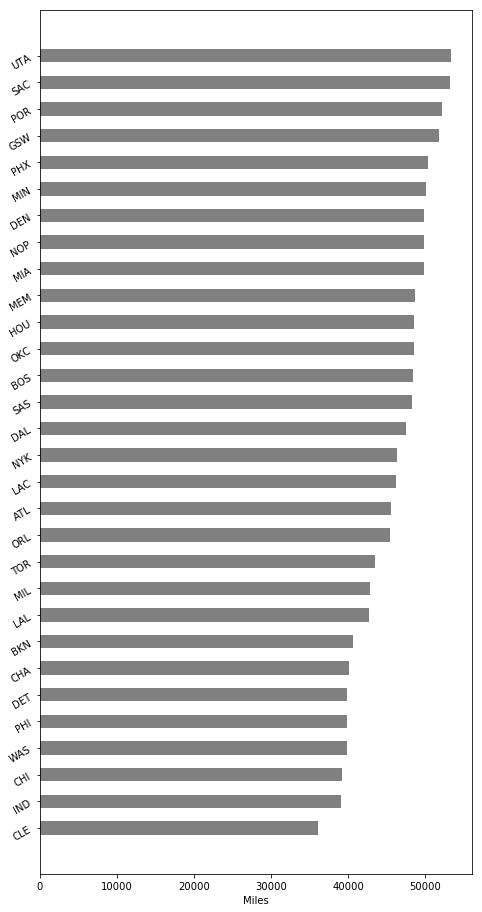

In [14]:
fig = plt.figure(figsize=(6, 12))

axis = fig.add_axes([0., 0., 1., 1., ])

axis.barh(bottom=range(0, len(travel_df)),
          width=travel_df['MILES'],
          left=0*len(travel_df), height=0.5,
          color='grey')

plt.yticks(range(0, len(travel_df)),
           [ID_TO_TEAM_NBA[x] for x in travel_df['TEAM_ID']],
           rotation=30)
plt.xlabel('Miles')
plt.show()

Interestingly and perhaps predictably, the top 8 teams in terms of estimated miles traveled are Western Conference teams. The bottom 8 teams are all Eastern Conference teams in fairly centrally-located cities within their conference. The difference between the bottom team (~36,000 miles) and the top team (~53,000 miles) is quite stark.

## Visualizing Back-to-Backs

The following sorts teams by the number of back-to-back sets played.

In [10]:
b2b_df = pd.DataFrame({'TEAM_ID': [x for x in BACK_TO_BACK.keys()],
                       'BACK2BACK': [BACK_TO_BACK[x] for x in BACK_TO_BACK.keys()]})

In [11]:
b2b_df = b2b_df.sort_values('BACK2BACK', ascending=True)

In [12]:
b2b_df

,BACK2BACK,TEAM_ID
9,11,1610612744
21,11,1610612753
2,11,1610612751
16,11,1610612749
28,11,1610612762
11,11,1610612754
10,11,1610612745
13,12,1610612747
18,12,1610612740
14,12,1610612763


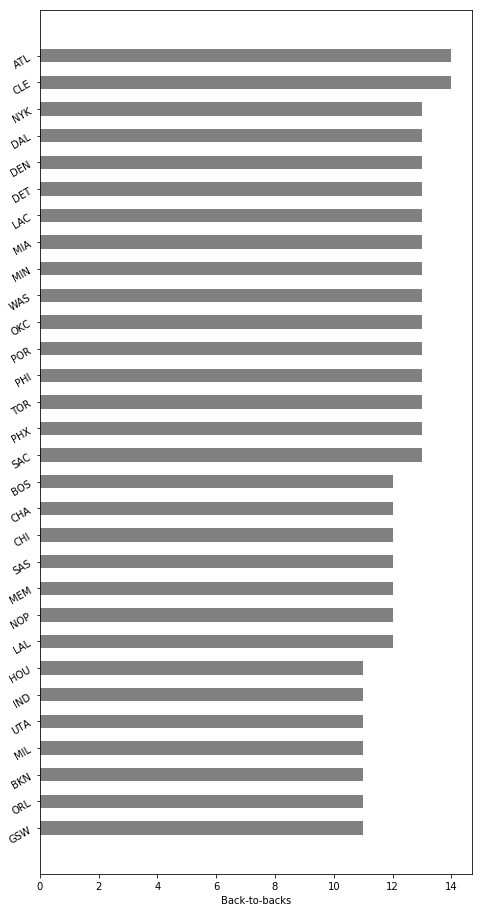

In [15]:
fig = plt.figure(figsize=(6, 12))

axis = fig.add_axes([0., 0., 1., 1., ])

axis.barh(bottom=range(0, len(b2b_df)),
          width=b2b_df['BACK2BACK'],
          left=0*len(b2b_df), height=0.5,
          color='grey')

plt.yticks(range(0, len(b2b_df)),
           [ID_TO_TEAM_NBA[x] for x in b2b_df['TEAM_ID']],
           rotation=30)
plt.xlabel('Back-to-backs')
plt.show()

Given recent efforts by the NBA to limit back-to-backs, the figure shows that all teams have back-to-backs in the 11-14 game range. With such a small range and limited volume, it seems that the NBA's efforts have been equally-distributed and successful. 

## Exploration

- Make an adjustment to the assumptions made about miles traveled and explore how that changes the results.
- Add games with 1, 2, and 3+ days of rest to the back-to-back chart. Are there wider ranges of days with a given number of rest than back-to-backs?
- Create another scheduling chart that has a meaningful takeaway. The Twitter account of [Ed Kupfer](https://twitter.com/EdKupfer) is a good place to generate ideas!